<a href="https://colab.research.google.com/github/leejielong/resnet/blob/main/ResNet-functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
#Load Cifar-10 dataset
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
### normalise te images to pixel values (0,1)
x_train, x_test = x_train/255.0, x_test/255.0

In [4]:
# check the shapes of the images
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
# check the distribution of classes
(unique, counts) = np.unique(y_train, return_counts=True)
test = dict(zip(unique,counts))
print(test)

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


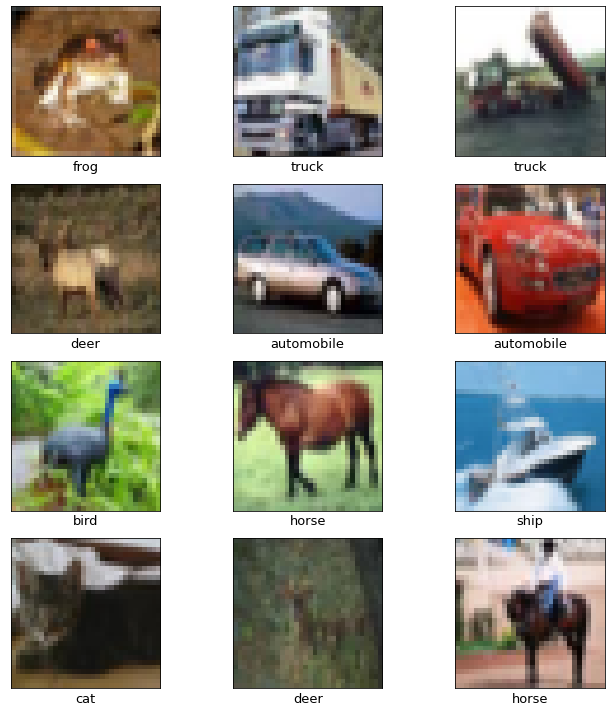

In [6]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(class_types[y_train[i][0]], fontsize=13)
plt.tight_layout()
plt.show()

In [7]:
# do one hot encoding for labels
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')


In [8]:
# Train-test split
from sklearn.model_selection import train_test_split
x_train,x_val, y_train, y_val = train_test_split(x_train,
                                                 y_train_categorical,
                                                 test_size=0.20,
                                                 stratify=y_train_categorical,
                                                 random_state=42,
                                                 shuffle=True)

In [9]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [11]:
## include data augmentation
batch_size = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2,
                                                                width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                horizontal_flip=True
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_datagen.flow(x_train,y_train,batch_size=batch_size)
valid_set_conv = valid_datagen.flow(x_val,y_val,batch_size=batch_size)

In [12]:
def res_identity(x,filter):
    #residual block for when dimensions dont change

    x_skip = x # to be used for addition later

    #first block
    x = Conv2D(filter, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block
    x = Conv2D(filter, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    #add input
    x = Add()([x,x_skip])
    x = Activation(activations.relu)(x)
    
    return x

In [13]:
def res_conv(x, s, filter):
    #residual block for when dimensions change
    #s determines the stride

    x_skip = x

    #first block
    x = Conv2D(filter, kernel_size=(3,3), strides=(s,s), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block
    x = Conv2D(filter, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    #shortcut
    x_skip = Conv2D(filter, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    #add input
    x = Add()([x,x_skip]) #second block and shortcut must have same dims
    x = Activation(activations.relu)(x)

    return x

In [14]:
def resnet50():

    input_im = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])) # (batch_size, 32,32,3)

    #1st stage (here we perform maxpooling)
    x = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(input_im) # (batch_size,16,16,64)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x) # (batch_size,8,8,64)

    #2nd stage
    x = res_identity(x, filter=64) #(batch_size,8,8,64)
    x = res_identity(x, filter=64)
    x = res_identity(x, filter=64)

    #3rd stage
    x = res_conv(x, s=2, filter=128) #(batch_size,4,4,128)
    x = res_identity(x, filter=128)
    x = res_identity(x, filter=128)
    x = res_identity(x, filter=128)

    #4th stage
    x = res_conv(x, s=2, filter=256) #(batch_size,2,2,256)
    x = res_identity(x, filter=256)
    x = res_identity(x, filter=256)
    x = res_identity(x, filter=256)
    x = res_identity(x, filter=256)
    x = res_identity(x, filter=256)

    #5th stage
    x = res_conv(x, s=2, filter=512) #(batch_size,1,1,512)
    x = res_identity(x, filter=512)
    x = res_identity(x, filter=512)

    # # Last stage
    x = AveragePooling2D((2,2), padding='same')(x) #(batch_size,1,1,512)
    x = Flatten()(x) #(batch_size,512)
    x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #(batch_size,10)

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model


In [ ]:
@tf.function
def train_step(x_train, y_train, x_test, y_test):
    with tf.GradientTape() as tape:
        preds = 


In [15]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr

lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay)

# def earlystop(mode):
#   if mode=='acc':
#     estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
#   elif mode=='loss':
#     estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
#   return estop

In [16]:
resnet50_model = resnet50()

In [17]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [18]:
resnet50_model.compile(loss='categorical_crossentropy', 
                       optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

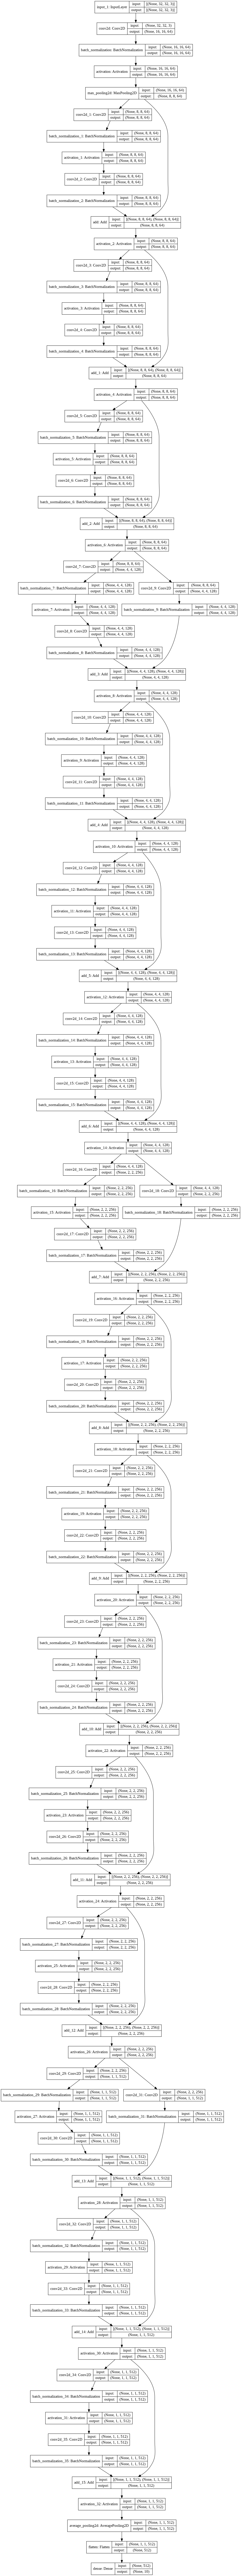

In [19]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [ ]:
batch_size=64 # test with 64, 128, 256

resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=160, 
                                  steps_per_epoch=x_train.shape[0]/batch_size, 
                                  validation_steps=x_val.shape[0]/batch_size, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])

Epoch 1/160
625/625 [==============================] - 30s 48ms/step - loss: 2.4078 - acc: 0.5005 - val_loss: 2.3585 - val_acc: 0.4240
Epoch 2/160
625/625 [==============================] - 30s 47ms/step - loss: 1.8914 - acc: 0.5463 - val_loss: 2.0855 - val_acc: 0.4460
Epoch 3/160
625/625 [==============================] - 30s 48ms/step - loss: 1.6428 - acc: 0.5857 - val_loss: 2.0014 - val_acc: 0.4537
Epoch 4/160
625/625 [==============================] - 30s 48ms/step - loss: 1.5529 - acc: 0.6034 - val_loss: 6.8501 - val_acc: 0.2539
Epoch 5/160
625/625 [==============================] - 30s 48ms/step - loss: 1.5487 - acc: 0.6162 - val_loss: 1.9502 - val_acc: 0.5105
Epoch 6/160
625/625 [==============================] - 30s 48ms/step - loss: 1.5081 - acc: 0.6317 - val_loss: 2.6473 - val_acc: 0.4227
Epoch 7/160
625/625 [==============================] - 30s 48ms/step - loss: 1.4062 - acc: 0.6530 - val_loss: 17.5116 - val_acc: 0.1000
Epoch 8/160
625/625 [==============================] -

In [ ]:
### Plot train and validation curves
loss = resnet_train.history['loss']
val_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
val_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', alpha=0.7, label='Train Loss')
plt.plot(epochs, val_loss, linestyle='-.', alpha=0.8, label='Valid Loss')
plt.ylim(0.3,100)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(epochs, acc, linestyle='--',alpha=0.7,label='Train Acc')
plt.plot(epochs, val_acc, linestyle='-.',alpha=0.78,label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()